## Notes

#### action space
- start with discrete first: actions represent buying/selling fixed percentage of just one stock to/from cash
- box or multi-binary `(extension)`

#### observations
- n-period returns history
- current portfolio allocations, current portfolio value, current profit `(extension)`
- extra features e.g autocorrelations, volume, OHLC, economic data, trading indicators, sentiment `(extension)`

#### reward
- return of the portfolio (will this incentivise short bursty improvements over steady gains?)
- reward is the portfolio value multiplied by some fraction of the number of time steps so far `(extension)` [more details](https://towardsdatascience.com/creating-a-custom-openai-gym-environment-for-stock-trading-be532be3910e)

#### other considerations
- trading fees (nowdays some brokers don't even take trading fees and make money just on the spread)
- visualization stacks the percentage allocations showing changes over time
- should there be a maximum episode length?

TODO: Restructure all this into one table


## Code

In [26]:
from gym import Env
from gym.spaces import Discrete, Box
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm
import time

from stable_baselines3 import DQN
from stable_baselines3.common.env_checker import check_env

In [27]:
train_data = pd.read_csv('train_data.csv', parse_dates=True, index_col='Date')
train_data.head()

,AAPL,GOOGL,MSFT
Date,,,
2022-01-04,0.987308,0.995917,0.982853
2022-01-05,0.973400,0.954124,0.961612
2022-01-06,0.983307,0.999800,0.992098
2022-01-07,1.000988,0.994697,1.000510
2022-01-10,1.000116,1.012061,1.000732


In [28]:
class PortOptEnv(Env):
    def __init__(self, df, window_size=14, order_size=0.1, starting_balance=1000, episode_length=90):
        
        self.df = df
        self.NUM_ASSETS = len(self.df.columns)
        self.NUM_DAYS = len(self.df)
        self.WINDOW_SIZE = window_size
        self.ORDER_SIZE = order_size
        self.PORTFOLIO_PRECISION = len(str(self.ORDER_SIZE).split('.')[-1])
        self.STARTING_BALANCE = starting_balance
        self.EPISODE_LENGTH = episode_length
        
        # each action represents buying or selling ORDER_SIZE percent of a single stock
        self.action_space = Discrete(self.NUM_ASSETS*2 + 1)
        # each observation is a WINDOW_SIZE day history of returns ending with the current return
        self.observation_space = Box(
            low = 0.0, # can this be higher? TODO
            high = 2.0, # can this be lower? TODO
            shape = (self.WINDOW_SIZE*self.NUM_ASSETS,), 
            dtype = np.float64
        )
        self.reset()
        
    def reset(self):
        self.balance = self.STARTING_BALANCE # total value of the portfolio
        # percentage allocations of all the assets in the portfolio e.g [1, 0, 0, 0] for 3 assets
        self.portfolio = np.insert(np.zeros(self.NUM_ASSETS), 0, 1.0)
        self.current_length = 0
        self.current_index = self.df.index.get_loc(self.df[self.WINDOW_SIZE:-self.EPISODE_LENGTH].sample().index[0]) # random starting index
        return self.get_observation()
    
    def get_observation(self):
        return self.df.iloc[self.current_index-self.WINDOW_SIZE+1: self.current_index+1].to_numpy().flatten()
        
    def step(self, action):
        
        # register action
        action = action - self.NUM_ASSETS # e.g possible actions for 3 stocks are {-3, -2, -1, 0, 1, 2, 3}
        action_index, action_sign = abs(action), np.sign(action)
        
        # update portfolio
        if action_sign > 0 and self.portfolio[0] > 0: # we can buy as long as we have cash
            self.portfolio[action_index] += self.ORDER_SIZE
            self.portfolio[0] -= self.ORDER_SIZE
        elif action_sign < 0 and self.portfolio[action_index] > 0: # we can sell as long as we have the asset we want to sell
            self.portfolio[action_index] -= self.ORDER_SIZE
            self.portfolio[0] += self.ORDER_SIZE
        else:
            pass
        self.portfolio = self.portfolio.round(decimals=self.PORTFOLIO_PRECISION) # round to avoid floating point error
        
        # update current_index
        self.current_index += 1
        self.current_length += 1
        if self.current_length >= self.EPISODE_LENGTH:
            done = True
        else:
            done = False
        
        # update balance
        old_balance = self.balance
        incoming_returns = self.df.iloc[self.current_index]
        self.balance = self.balance * (self.portfolio[0] + (incoming_returns * self.portfolio[1:]).sum())
        if self.balance <= 0:
            done = True
        
        # compute reward
        reward = self.balance/old_balance
        
        # get new observation
        observation = self.get_observation()
        
        # return step data
        return observation, reward, done, {}
    
    def render(self):
        pass

In [29]:
env = PortOptEnv(df = train_data)
check_env(env)

In [30]:
env = PortOptEnv(df = train_data)

100%|██████████| 1000/1000 [00:23<00:00, 43.21it/s]


Text(0.5, 1.0, 'Average: 0.022995477199554443')

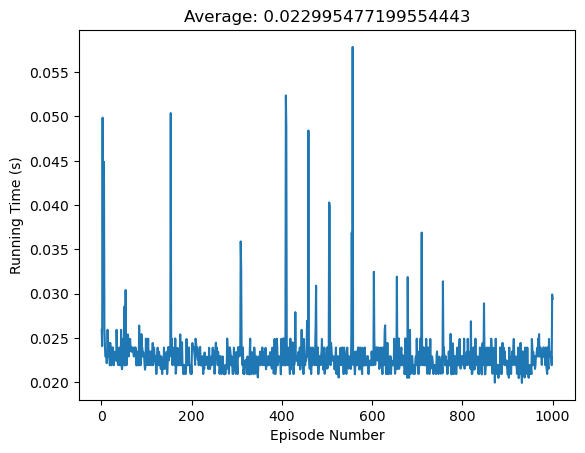

In [31]:
episodes = 1000
running_times = []

for episode in tqdm(range(episodes)):
    
    start_time = time.time()
    
    obs = env.reset()
    done = False
    while not done:
        action = np.random.randint(env.action_space.n)
        obs, reward, done, info = env.step(action)
    
    end_time = time.time()
    running_times.append(end_time - start_time)

plt.plot(range(1, episodes+1), running_times);
plt.xlabel('Episode Number');
plt.ylabel('Running Time (s)');
plt.title(f'Average: {np.mean(running_times)}')

In [32]:
# # Testing if it runs
# episodes = 1000
# for episode in range(episodes):
#     obs = env.reset()
#     done = False
#     episode_length = 0
    
#     while not done:
#         action = env.action_space.sample()
#         obs, reward, done, info = env.step(action)
#         episode_length += 1
    
#     print(f'Episode {episode} \t Length {episode_length}')
        
# env.close()

In [33]:
# # Testing actions to portfolio
# episodes = 5
# for episode in range(episodes):
#     obs = env.reset()
#     done = False
    
#     while not done:
#         action = env.action_space.sample()
#         obs, reward, done, info = env.step(action)
#         print(action-env.NUM_ASSETS, '\t', env.portfolio)
#     print('')
    
# env.close()

In [34]:
# # Testing balance calculations
# episodes = 5
# for episode in range(episodes):
#     obs = env.reset()
#     done = False
#     expected_balance = 1000
    
#     while not done:
#         action = env.action_space.sample()
#         obs, reward, done, info = env.step(action)
#         expected_balance *= reward
#         print(reward, '\t', env.balance, '\t', expected_balance)
#     print('')
    
# env.close()

Should I write test cases? Should I test with synthetic data?

In [35]:
# # Testing if it runs
# episodes = 5
# for episode in range(episodes):
#     obs = env.reset()
#     done = False
#     episode_length = 0
    
#     while not done:
#         action = env.action_space.sample()
#         obs, reward, done, info = env.step(action)
#         episode_length += 1
        
#         print(f'Action \t {action} \t Observation {obs} \t Reward {reward}')
    
#     print(f'Episode {episode} \t Length {episode_length}')
        
# env.close()